# ***Vision Transformer***

#### ***The standard Transformer takes a 1D sequence of token embeddings as input. Since images are 2D, ViT converts them into a sequence of patches before feeding them to the Transformer.***

---

![](https://raw.githubusercontent.com/google-research/vision_transformer/main/vit_figure.png)

---



# Steps

## Step 1: Split the Image into Patches

**Input:** Original image  
$$
x \in \mathbb{R}^{H \times W \times C}
$$  
where

- \$H, W\$: image height & width  
- \$C\$: number of channels  

The image is divided into non-overlapping patches of size \$P \times P\$.

Each patch is flattened into a vector:  
$$
x_p \in \mathbb{R}^{N \times (P^2 \cdot C)}
$$  
where  
$$
N = \frac{H W}{P^2} \quad \text{(number of patches)}
$$

These flattened patches are projected to a fixed dimension \$D\$ using a trainable linear projection:  
$$
z^0 = [x_{class}; x_p W_E] + E_{pos}
$$  
where

- \$W_E\$: linear projection matrix  
- Output = Patch Embeddings
---
## Step 2: Add the [CLS] Token

Inspired by BERT, a learnable [class] token \$(x_{class})\$ is prepended to the sequence of patch embeddings.

After passing through the Transformer encoder, the final state of this token \$(z^0_L)\$ is used as the image representation.

A classification head is attached:

- Pre-training: MLP with one hidden layer  
- Fine-tuning: Single linear layer
---
## Step 3: Add Position Embeddings

Transformers are order-agnostic, so positional information must be added.

ViT uses 1D learnable positional embeddings.

More advanced 2D-aware embeddings were tested but showed no significant improvement.

The resulting sequence of vectors is fed into the Transformer Encoder.
---
## Step 4: Transformer Encoder

The encoder follows the standard Transformer architecture (Vaswani et al., 2017).

Each encoder layer consists of:

- Multi-Head Self-Attention (MSA)  
- MLP Block (2 fully connected layers with GELU activation)

LayerNorm (LN) is applied before every block.

Residual connections are applied after every block.

## Going to replicate ViT-Base

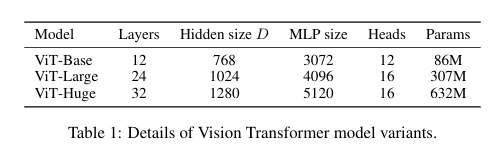

# Mathematical Formulation of ViT

The data flow through the encoder can be described as follows:

---

## Step 1: Input Embeddings

We construct the input sequence by combining:  

- The **[CLS] token** (\$x_{\text{class}}\$)  
- The **patch embeddings** (\$x_1, x_2, \dots, x_N\$)  
- The **positional embeddings** (\$E_{\text{pos}}\$)  

$$
z_0 =
\begin{bmatrix}
x_{\text{class}} \\
x_1 \\
x_2 \\
\vdots \\
x_N
\end{bmatrix}
+ E_{\text{pos}}
$$

In pseudo code
```python
x_input = [class_token,image_patch_1,image_patch_2,...,image_path_n] + [class_token_pos,image_patch_1_pos,image_patch_2_pos,...,image_patch_n_pos]
```
---

## Step 2: Multi-Head Self-Attention (MSA)

Apply LayerNorm, then MSA, and add a residual connection:  

$$
z_1 = \text{MSA}(\text{LN}(z_0)) + z_0
$$

In pseudocode

```python
x_output_MSA = MSA_layer(LN_layer(x_input)) + x_input # residual connection
```
---

## Step 3: MLP Block
The **MLP block** in the Transformer encoder contains two fully connected layers with a **GELU non-linearity**.

Pass through a 2-layer MLP with GELU activation (and residual connection):  

$$
z = \text{MLP}(\text{LN}(z_1)) + z_1
$$

In PseudoCode
```python
x_output_MLP = MLP_layer(x_output_MSA) + x_output_MSA # residual connection
```
---

## Step 4: Final Representation

After \$L\$ layers, the final output is normalized:  

$$
y = \text{LN}(z_0^L)
$$

Here, the representation of the **[CLS] token** in \$y\$ is used for classification.
```python
y = LN_layer(x_output_MLP)
```
---

## Dimensions

- Patch embedding projection:  
  $$
  E \in \mathbb{R}^{(P^2 C) \times D}
  $$

- Positional embeddings:  
  $$
  E_{\text{pos}} \in \mathbb{R}^{(N+1) \times D}
  $$

- Number of layers:  
  $$
  l = 1, \dots, L
  $$

## Inductive Bias: CNNs vs Vision Transformers
In ML, $Inductive bias$ = the assumptions a model makes about the data before learning from it.

It’s like giving the model a head start with some built-in knowledge about how data is structured.

🔹 CNNs – Strong Image-Specific Inductive Bias

- Locality: Convolutions only look at small local regions.

- 2D Neighborhood Structure: Operates directly on pixel grids (height × width).

- Translation Equivariance: Feature detected in one location can be recognized anywhere.

✅ Makes CNNs data-efficient (good with small datasets).

⚠️ But harder to capture long-range/global dependencies.

🔹 Vision Transformer (ViT) – Weak Image-Specific Inductive Bias

- MLP layers: Local + translationally equivariant.

- Self-attention layers: Global, no assumption of locality or grid structure.

- 2D neighborhood structure is only used:

- At input (cutting image into patches).

- At fine-tuning (adjusting positional embeddings for different resolutions).

Positional embeddings:

- At initialization, carry no spatial information.

- Model must learn patch-to-patch relations (like left/right/above) from scratch.

⚠️ Requires large datasets (e.g., JFT-300M) to learn effectively.

✅ More flexible & scalable once trained.

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms

try:
  from torchinfo import summary
except:
  print(f"[INFO] Couldn't find torchinfo.. installing it")
  !pip install -q torchinfo
  from torchinfo import summary

[INFO] Couldn't find torchinfo.. installing it


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


* Input Image: ${H} \times{W}\times{C}$
* Output Image: ${N \times\left(P ^ {2} \cdot C\right)}$
* N: number of patches = $$
N = \frac{H W}{P^2} \quad \text{(number of patches)}
$$
* D: constant latent vector size / embedding dimension -> Each patch will become into D sized embeddings

In [4]:
# ViT-B/16
height = 224
width = 224
color_channels = 3
patch_size = 16 # see table 5 as ViT-B/16 outperformed ViT-B/32

number_of_patches = (height * width) // patch_size**2
print(number_of_patches)

196


In [5]:
embedding_layer_input_layer = (height,width,color_channels)

embedding_layer_output_layer = (number_of_patches,patch_size**2 * color_channels)
print(f"Input Shape (single 2D image): {embedding_layer_input_layer}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_layer}-> (number of patches,embedding_dimension)")

Input Shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768)-> (number of patches,embedding_dimension)


### Loading an Image

In [6]:
import requests
response = requests.get("https://cdn.wallpapersafari.com/44/55/kp50Ri.jpg")
with open("image.png",'wb') as f:
  f.write(response.content)

(1024, 640)

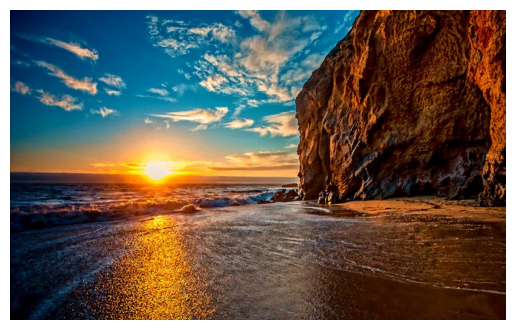

In [7]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("image.png")
plt.imshow(img)
plt.axis("off")
img.size

In [8]:
transformed_img = manual_transforms(img)
transformed_img.shape

torch.Size([3, 224, 224])

### Permuting the image to visualize

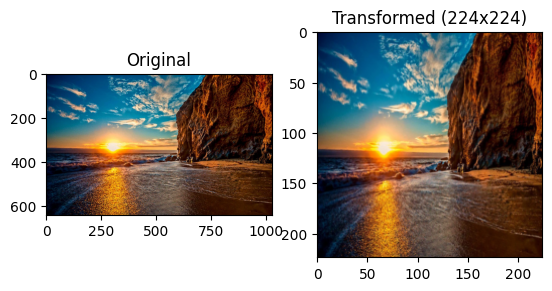

In [9]:
import matplotlib.pyplot as plt

# Convert tensor back to image for display
img_tensor = transformed_img.permute(1, 2, 0)  # (H, W, C)

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original")

plt.subplot(1, 2, 2)
plt.imshow(img_tensor)
plt.title("Transformed (224x224)")

plt.show()


Original image shape: (224, 224, 3)

After slicing: (16, 224, 3)

Result: the top 16-pixel band of the image will be shown.

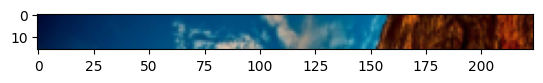

In [10]:
patch_size = 16
# plt.figure(figsize=(patch_size,patch_size))
plt.imshow(img_tensor[:patch_size,:,:])

### Patching only top layer of the image





Number of patches per row: 14
Patch size: 16 pixels x 16 pixels


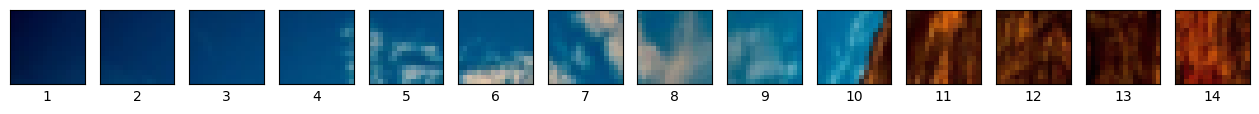

In [11]:
img_size = 224
patch_size = 16
num_patches = img_size // patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

fig, axis = plt.subplots(nrows=1,
                         ncols=num_patches,
                         sharex=True,
                         sharey=True,
                         figsize=(patch_size,patch_size))
for i,patch in enumerate(range(0,img_size,patch_size)):
  axis[i].imshow(img_tensor[:patch_size,patch:patch+patch_size,:])
  axis[i].set_xlabel(i+1)
  axis[i].set_xticks([])
  axis[i].set_yticks([])

## Patching entire Image


Number of patches per row: 14
Number of patches per col: 14
Total patches: 196


Text(0.5, 0.98, 'Nature Image Patchified')

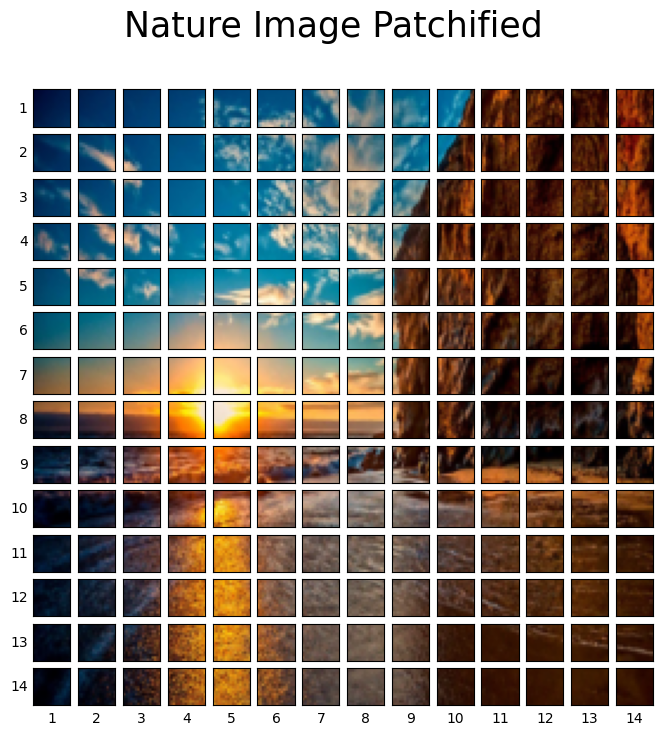

In [12]:
img_size = 224
patch_size = 16
num_patches = img_size // patch_size
print(f"Number of patches per row: {num_patches}\nNumber of patches per col: {num_patches}\nTotal patches: {num_patches*num_patches}")
fig, axis = plt.subplots(nrows=num_patches,
                         ncols=num_patches,
                         sharex=True,
                         sharey=True,
                         figsize=(8,8))

for row, patch_row in enumerate(range(0,img_size,patch_size)):
  for col, patch_col in enumerate(range(0,img_size,patch_size)):
    axis[row,col].imshow(img_tensor[patch_row:patch_row+patch_size,
                                    patch_col:patch_col+patch_size,
                                    :])
    axis[row,col].set_ylabel(row+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
    axis[row,col].set_xlabel(col+1)
    axis[row,col].set_xticks([])
    axis[row,col].set_yticks([])
    axis[row,col].label_outer()

fig.suptitle("Nature Image Patchified",fontsize=25)

## Turning Patched Images into Embeddings

Hybrid Architecture. As an alternative to raw image patches, the input sequence can be formed from feature maps of a CNN (LeCun et al., 1989). In this hybrid model, the patch embedding projection E (Eq. 1) is applied to patches extracted from a CNN feature map. As a special case, the patches can have spatial size $1 \times 1$, which means that the input sequence is obtained by simply flattening the spatial dimensions of the feature map and projecting to the Transformer dimension. The classification input embedding and position embeddings are added as described above.

In [13]:
from torch import nn

patch_size = 16

conv2d = nn.Conv2d(in_channels=3,#colour_channels
                   out_channels=768, # D size from Table 1
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

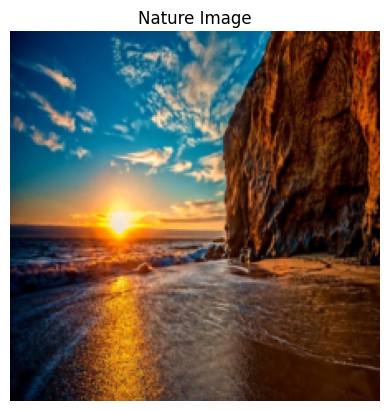

In [14]:
plt.imshow(img_tensor)
plt.title("Nature Image")
plt.axis(False)
plt.show()

In [15]:
# adding batch dimension
img_conv = conv2d(transformed_img.unsqueeze(0) )
print(f"Output of conv2d layer shape: {img_conv.shape}")

Output of conv2d layer shape: torch.Size([1, 768, 14, 14])


[1, 768, 14, 14] -> [batch_size, embedding_dim, feature_map_height, feature_map_width]

224 / 16 = 14 patches along height & width

So total patches = 14 * 14 = 196

Flatten patches (for transformer input)

Random convolutional feature maps from indexes: [297, 191, 370, 305, 753]


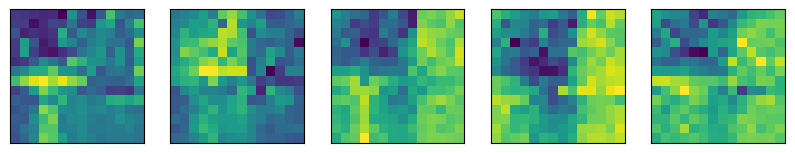

In [16]:
import random
random_indexes = random.sample(range(0,768),k=5)
print(f"Random convolutional feature maps from indexes: {random_indexes}")
fig,axis = plt.subplots(nrows=1,ncols=5,figsize=(10,10))

for i,idx in enumerate(random_indexes):
  img_conv_feature_map = img_conv[:,idx,:,:]
  axis[i].imshow(img_conv_feature_map.squeeze().detach().numpy())
  axis[i].set(xticklabels=[],yticklabels=[],xticks=[],yticks=[])

In [17]:
flatten_layer = nn.Flatten(start_dim=2,end_dim=3)
img_out_of_conv_flattened = flatten_layer(img_conv)
print(img_out_of_conv_flattened.shape)

torch.Size([1, 768, 196])


In [18]:
img_out_of_conv_flattened_permute = img_out_of_conv_flattened.permute(0,2,1)
print(f"{img_out_of_conv_flattened_permute.shape} -> [batch_size,number_of_patches,embeddings]")

torch.Size([1, 196, 768]) -> [batch_size,number_of_patches,embeddings]


(np.float64(-0.5), np.float64(195.5), np.float64(0.5), np.float64(-0.5))

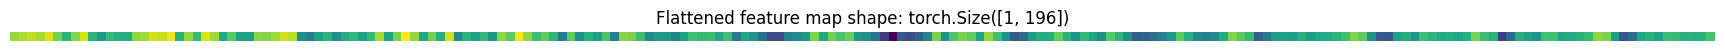

In [19]:
flattenend_feature_map = img_out_of_conv_flattened_permute[:,:,0]
plt.figure(figsize=(22,22))
plt.imshow(flattenend_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {flattenend_feature_map.shape}")
plt.axis("off")

## Turning the ViT patch embedding layer into PyTorch module
1.  Create a class classed PatchEmbeddig that inherits from `nn.Module`
2. Initialize with appropriate hyperparameters.
3. Create a layer to turn an image into embedding patches using `nn.conv2d()`.
4. Create a layer to flatten the feature maps of the output of the layer 3.
5. Define `forward()` methid that defines the forward computation.

In [20]:
from torch import nn
class PatchEmbedding(nn.Module):
  """Turns a 2D input image into a 1D sequence of learnable embedding vector

  Args:
    in_channels (int): Number of colour channels for the input image.
    patch_size (int): Size of patches to convert input image into.
    out_channels (int): Size of embedding to turn each patch images into.

  """
  def __init__(self,
               in_channels:int=3,
               patch_size:int=16,
               embedding_dim:int=768):
    super().__init__()
    # 1. Converting Image into embedding patches
    self.patcher = nn.Conv2d(
        in_channels=in_channels,
        out_channels=embedding_dim,
        kernel_size=patch_size,
        stride=patch_size,
        padding=0
    )
    # 2. Flattening these embedding patches
    self.flatten = nn.Flatten(
        start_dim=2,
        end_dim=3
    )
  def forward(self,x):
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {patch_size}"
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)
    return x_flattened.permute(0,2,1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [21]:
patchify = PatchEmbedding()
print(f"Input image size: {transformed_img.unsqueeze(0).shape}")
patch_embedded_image = patchify(transformed_img.unsqueeze(0))
print(f"Output image size: {patch_embedded_image.shape}")

Input image size: torch.Size([1, 3, 224, 224])
Output image size: torch.Size([1, 196, 768])


### Creating Class_Token

Similar to BERT's [class] token, we prepend a *learnable embedding* to the sequence of embedded patches ( $\mathbf{z}_0^0=\mathbf{x}_{\text {class }}$ ), whose state at the output of the Transformer encoder ( $\mathbf{z}_L^0$ ) serves as the image representation y.

In [22]:
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size,embedding_dimension

(1, 768)

In [23]:
# In PyTorch, a learnable parameter is created with nn.Parameter
class_token = nn.Parameter(torch.randn(1,1,embedding_dimension))
print(f"Shape of the class token: {class_token.shape} -> [batch_size,number_of_patches,dimensions]")
print(f"A learnable parameter need to update during backpropagation so requires_grad = {class_token.requires_grad}")

Shape of the class token: torch.Size([1, 1, 768]) -> [batch_size,number_of_patches,dimensions]
A learnable parameter need to update during backpropagation so requires_grad = True


In [24]:
patch_embedded_image_with_class_token = torch.cat((class_token,patch_embedded_image),dim=1) #dim=1 number_of_patches
print(f"{patch_embedded_image_with_class_token.shape} -> [batch_size,class_token + number_of_patches,dimensions] ")

torch.Size([1, 197, 768]) -> [batch_size,class_token + number_of_patches,dimensions] 


## Position Embeddings

 > Position embeddings are added to the patch embeddings to retain positional information

 >  We use standard learnable 1D position embeddings

In [25]:
batch_size = patch_embedded_image_with_class_token.shape[0]
number_of_patches = patch_embedded_image_with_class_token.shape[1]
embedding_dimension = patch_embedded_image_with_class_token.shape[-1]
batch_size,number_of_patches,embedding_dimension

(1, 197, 768)

In [26]:
position_embed = nn.Parameter(torch.randn(batch_size,number_of_patches,embedding_dimension))
# print(f"{position_embed}")
print(f"{position_embed.shape}")

torch.Size([1, 197, 768])


In [27]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_token + position_embed
print(patch_and_position_embedding.shape)

torch.Size([1, 197, 768])


## Turning the ViT patch embedding layer into PyTorch module

$\mathbf{z}_0=\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_p^1 \mathbf{E} ; \mathbf{x}_p^2 \mathbf{E} ; \cdots ; \mathbf{x}_p^N \mathbf{E}\right]+\mathbf{E}_{\text {pos }}$

---

$\mathbf{E} \in \mathbb{R}^{\left(P^2 \cdot C\right) \times D}, \mathbf{E}_{p o s} \in \mathbb{R}^{(N+1) \times D}$

---
1.  Create a class classed ViTEmbeddig that inherits from `nn.Module`
2. Initialize with appropriate hyperparameters.
3. Create a layer to turn an image into embedding patches using `nn.conv2d()`.
4. Create a layer to flatten the feature maps of the output of the layer 3.
5. Create class token and position embedding
6. Define `forward()` methid that defines the forward computation.


In [28]:
from torch import nn
class ViTEmbedding(nn.Module):
  """ Turns a 2D image into 1D sequence of learnable embedding vector

  Args:
   in_channels (int): Number of colour channels for the input image. patch_size (int): Size of patches to convert input image into. out_channels (int): Size of embedding to turn each patch images into embeddings.

   """
  # Initialize hyperparameters
  def __init__(self,
               in_channels:int=3,
               patch_size:int=16,
               embedding_dimension:int=768,
               image_size:int=224,
               embedding_dropout:float=0.1):
    super().__init__()
    assert image_size % patch_size == 0 ,f"Image size must be divisible by patch size, image size: {image_size}, patch size: {patch_size}."

    # Converting Image into embedding patches
    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dimension,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)

    num_patches = (image_size * image_size)//patch_size**2

    # Flattenning the embeddings
    self.flatten = nn.Flatten(start_dim=2,
                              end_dim=3)


    # Learnable [CLS] token
    self.class_token = nn.Parameter(torch.randn(1,1,embedding_dimension))

    # Learnable positional embeddings
    self.positional_embeddings = nn.Parameter(torch.randn(1,num_patches+1,embedding_dimension))

    # Embedding and Patch Dropout
    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

  def forward(self,x):
    B = x.size(0) # batch_size
    # [B,C,H,W] -> [B,D,H//ps,W//ps]
    x_pathced = self.patcher(x)
    # [B,D,H//ps,W//ps] -> [B,D,N]
    x_flattened = self.flatten(x_pathced)
    # [B,D,N] -> [B,N,D]
    x = x_flattened.permute(0,2,1)
    # prepend class token => [B,1,D]
    cls_token = self.class_token.expand(B,-1,-1)
    x_with_cls = torch.cat((cls_token,x),dim=1)
    # add positional embeding => [B,N+1,D]
    x_out = x_with_cls + self.positional_embeddings
    x_out = self.embedding_dropout(x_out)
    return x_out

In [29]:
vit_embed_layer = ViTEmbedding()
z = vit_embed_layer(transformed_img.unsqueeze(0))
z.shape

torch.Size([1, 197, 768])

## Adding MultiSelfAttention and Layer Normalization
$$z_1 = \text{MSA}(\text{LN}(z_0)) + z_0$$

## Going to replicate ViT-Base

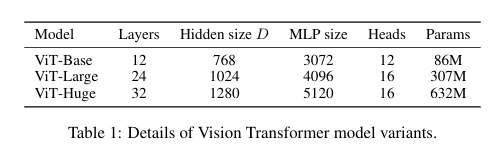

In [30]:
# class Multi
from torch.nn import MultiheadAttention,LayerNorm
MSA = MultiheadAttention(embed_dim=embedding_dimension,num_heads=12,dropout=0)
LR = LayerNorm(normalized_shape=embedding_dimension)

In [31]:
normalized = LR(z)
msa = MSA(query=normalized,key=normalized,value=normalized,need_weights=False)

In [32]:
msa[0].shape

torch.Size([1, 197, 768])

In [33]:
from torch.nn import LayerNorm,MultiheadAttention
from torch import nn
class MultiheadSelfAttentionBlock(nn.Module):
  """
  Utilizes torch.MultiheadAttention and torch.LayerNorm to replicate equation 2 of ViT paper
  """
  def __init__(self,
               embed_dim:int = embedding_dimension,
               num_heads:int = 12 # Number of Layers (Table 1)
               ):
    super().__init__()
    # Initialize Layer Norm
    self.Layer_Norm = LayerNorm(normalized_shape=embed_dim)

    # Initialize MultiSelfHeadAttention
    self.MSA = MultiheadAttention(embed_dim=embed_dim,num_heads=num_heads)

  def forward(self,x):
    x = self.Layer_Norm(x)
    attn_output,attention_weights = self.MSA(query=x,
                 key=x,
                 value=x,
                 need_weights=False)
    return x

ViTEmbedding (Equation1) -> MultiheadSelfAttentionBlock (Equation2)


In [34]:
vit_embed_layer = ViTEmbedding()
x = vit_embed_layer(transformed_img.unsqueeze(0))
print(f"Shape of Image After Converting it into Embeddings: {x.shape}")
MSA_Block = MultiheadSelfAttentionBlock()
x_out_of_msa_block = MSA_Block(x)
print(f"After MSA Block {x_out_of_msa_block.shape}")

Shape of Image After Converting it into Embeddings: torch.Size([1, 197, 768])
After MSA Block torch.Size([1, 197, 768])


## Creating MLP Block with Layer Normalization

$$
z = \text{MLP}(\text{LN}(z_1)) + z_1
$$
The MLP contains two layers with GELU non-linearity

linear -> non-linear -> dropout -> linear -> dropout

 Dropout,when used, is applied after
 every dense layer except for the qkv-projections and directly after adding positional- to patch
 embeddings.

In [35]:
from torch import nn
class MultiLayerPerceptron(nn.Module):
  """
  Utilizes torch.nn.Sequential Layer to build MLP and torch.LayerNorm to replicate equation 3 of ViT paper
  """
  def __init__(self,
               embedding_dimension:int=768,
               mlp_size:int=3072,
               dropout:float=0.1,
               ):
    super().__init__()

    # Layer Norm
    self.layer_norm = torch.nn.LayerNorm(normalized_shape=embedding_dimension)

    # Create Multi Layer Perceptron
    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dimension,
                  out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size,
                  out_features=embedding_dimension),
        nn.Dropout(p=dropout)
    )

  def forward(self,x):
    x_normalized = self.layer_norm(x)
    return self.mlp(x_normalized)

ViTEmbedding (Equation1) -> MultiheadSelfAttentionBlock (Equation2) -> MultiLinearPerceptron (Equation3)

In [36]:
vit_embed_layer = ViTEmbedding()
x = vit_embed_layer(transformed_img.unsqueeze(0))
# print(x)
print(f"Shape of Image After Converting it into Embeddings: {x.shape}")
MSA_Block = MultiheadSelfAttentionBlock()
x_out_of_msa_block = MSA_Block(x)
# print(x_out_of_msa_block)
print(f"After MSA Block {x_out_of_msa_block.shape}")
MLP_Block = MultiLayerPerceptron()
x_out_of_mlp_block = MLP_Block(x_out_of_msa_block)
# print(x_out_of_mlp_block)
print(f"After MLP Block {x_out_of_mlp_block.shape}")

Shape of Image After Converting it into Embeddings: torch.Size([1, 197, 768])
After MSA Block torch.Size([1, 197, 768])
After MLP Block torch.Size([1, 197, 768])


In [37]:
class TransformerEncoder(nn.Module):
  def __init__(self,
               embedding_dimension:int=768,
               num_heads:int=12, # Table 1,
               mlp_size:int=3072, # Table 1,
               mlp_dropout:float=0.1,
               att_dropout:int=0):
    super().__init__()
    self.MSA = MultiheadSelfAttentionBlock(
                                          embed_dim=embedding_dimension,
                                          num_heads=num_heads)
    self.MLP = MultiLayerPerceptron(                                    embedding_dimension=embedding_dimension,
    dropout=mlp_dropout,
    mlp_size=mlp_size)

  def forward(self,x):
    x = self.MSA(x) + x # x-> residual connection
    x = self.MLP(x) + x
    return x

In [38]:
transformer_encoder = TransformerEncoder()
transformer_encoder(x).shape

torch.Size([1, 197, 768])

In [39]:
from torchinfo import summary

summary(model=transformer_encoder,
        input_size=(1,197,768),
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
TransformerEncoder (TransformerEncoder)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (MSA)      [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (Layer_Norm)            [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (MSA)          --                   [1, 197, 768]        2,362,368            True
├─MultiLayerPerceptron (MLP)             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)            [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                  [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                   [1, 197, 768]        [1, 197, 3072]       2,362,368            True
│    │    └─GE

In [40]:
class VitTransformer(nn.Module):
    def __init__(self,
                 in_channels:int=3,
                 embedding_dimension:int=768,
                 num_transformer_layers:int=12,
                 patch_size:int=16,
                 image_size:int=224,
                 num_heads:int=12,
                 mlp_size:int=3072,
                 mlp_dropout:float=0.1,
                 att_dropout:int=0,
                 embedding_dropout:float=0.1,
                 num_classes:int=1000):
        super().__init__()

        assert image_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {image_size}, patch size: {patch_size}."

        self.embedding = ViTEmbedding(
            in_channels=in_channels,
            patch_size=patch_size,
            embedding_dimension=embedding_dimension,
            image_size=image_size,
            embedding_dropout=embedding_dropout
        )

        self.encoder = nn.Sequential(
            *[TransformerEncoder(
                embedding_dimension=embedding_dimension,
                num_heads=num_heads,
                mlp_size=mlp_size,
                mlp_dropout=mlp_dropout,
                att_dropout=att_dropout
            ) for _ in range(num_transformer_layers)]
        )

        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dimension),
            nn.Linear(in_features=embedding_dimension, out_features=num_classes)
        )

    def forward(self, x):
      x_embed = self.embedding(x)         # [B, 197, 768]
      x_encoded = self.encoder(x_embed)   # [B, 197, 768]
      cls_token = x_encoded[:, 0]         # [B, 768]
      x_classified = self.classifier(cls_token) # [B, num_classes]
      return x_classified


In [41]:
vit = VitTransformer()
print(vit)

VitTransformer(
  (embedding): ViTEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
    (embedding_dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Sequential(
    (0): TransformerEncoder(
      (MSA): MultiheadSelfAttentionBlock(
        (Layer_Norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (MSA): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (MLP): MultiLayerPerceptron(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (1): TransformerEncod

In [42]:
out = vit(transformed_img.unsqueeze(0))

In [43]:
out.shape

torch.Size([1, 1000])

# Training ViT on CIFAR-10 Dataset

In [44]:
import torch
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [46]:
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.ToTensor()
])
test_tranform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor()
])

In [47]:
train_data = CIFAR10(root="data",
                     train=True,
                     transform=train_transform,
                     download=True)
test_data = CIFAR10(root="data",
                    train=False,
                    transform=test_tranform,
                    download=True)

100%|██████████| 170M/170M [00:14<00:00, 11.4MB/s]


In [48]:
len(train_data),len(test_data)

(50000, 10000)

In [49]:
class_names = train_data.classes

In [50]:
image,target = train_data[random.randint(1,50000)]
image.shape

torch.Size([3, 224, 224])

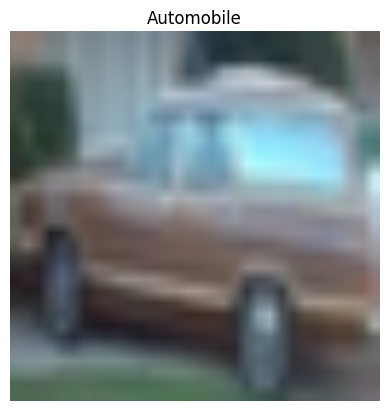

In [51]:
img_permuted = image.permute(1,2,0)
plt.imshow(img_permuted)
plt.axis("off")
plt.title(class_names[target].capitalize())
plt.show()

In [63]:
from torch.utils.data import Subset

# Keep only first 2000 training samples
small_train = Subset(train_data, range(2000))

# Keep only first 300 test samples
small_test = Subset(test_data, range(300))



In [64]:
import os
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=small_train,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=os.cpu_count() or 1)
test_dataloader = DataLoader(dataset=small_test,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count() or 1,
                             )

In [67]:
len(small_test)

300

In [65]:
a = next(iter(train_dataloader))
a[1],len(a[0])

(tensor([0, 4, 8, 0, 9, 6, 6, 9, 2, 3, 6, 3, 4, 4, 0, 0, 0, 6, 2, 8, 6, 2, 2, 7,
         1, 1, 5, 9, 3, 7, 4, 5]),
 32)

In [68]:
from typing import Dict,List
def plot_predictions(results:Dict[str,List[float]]):
  """ Plots training curves of a results dictionary """
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  acc = results["train_acc"]
  test_acc = results["test_acc"]

  epochs = range(len("train_loss"))

  plt.figure(figsize=(15,4))
  plt.subplot(1,2,1)
  plt.plot(epochs,loss,label="train_loss")
  plt.plot(epochs,test_loss,label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs,acc,label="train_accuracy")
  plt.plot(epochs,test_acc,label="test accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

In [70]:
def train_step(model:torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device:torch.device
               ):
  """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
      model: A PyTorch model to be trained.
      dataloader: A DataLoader instance for the model to be trained on.
      loss_fn: A PyTorch loss function to minimize.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
      A tuple of training loss and training accuracy metrics.
      In the form (train_loss, train_accuracy). For example:
  """
  model.to(device)
  model.train()

  train_loss,train_acc = 0,0

  for batch, (X,y) in enumerate(dataloader):
    # Move data to target device
    X, y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred,y)

    train_loss += loss.item()

    optimizer.zero_grad()

    loss.backward()
    optimizer.step()

    y_pred_class = torch.argmax(y_pred,dim=1)
    train_acc += (y_pred_class == y).sum().item()

  train_loss /= len(dataloader)
  train_acc /= len(dataloader.dataset)

  print(f"Train Loss: {train_loss:.3f} | Train Acc: {train_acc:.3f}")
  return train_loss,train_acc

def test_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    device: torch.device
):
    """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
  """
    model.to(device)
    model.eval()
    test_loss, correct_preds = 0, 0

    with torch.inference_mode():
        for batch, (X_t, y_t) in enumerate(dataloader):
            X_t, y_t = X_t.to(device), y_t.to(device)

            test_logits = model(X_t)
            loss = loss_fn(test_logits, y_t)
            test_loss += loss.item()

            test_logits_class = torch.argmax(test_logits, dim=1)
            correct_preds += (test_logits_class == y_t).sum().item()

    test_loss /= len(dataloader)
    test_acc = correct_preds / len(dataloader.dataset) # type: ignore

    print(f"Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.3f}")
    return test_loss,test_acc

In [71]:
from tqdm.auto import tqdm
import torch
from typing import Optional

def train(
    num_epochs: int,
    model: torch.nn.Module,
    train_loader: torch.utils.data.DataLoader,
    test_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device,):

    """Trains and tests a PyTorch model.

  Passes a target PyTorch models through train_step() and test_step()
  functions for a number of epochs, training and testing the model
  in the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]}
    For example if training for epochs=2:
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]}
  """
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
    }

    for epoch in tqdm(range(num_epochs)):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # Training
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_loader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device,
        )

        # Testing
        test_loss, test_acc = test_step(
            model=model,
            dataloader=test_loader,
            loss_fn=loss_fn,
            device=device,
        )

        # Save results
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [72]:
from torch import optim
model = VitTransformer(in_channels=3,
                 embedding_dimension=768,
                 num_transformer_layers=12,
                 patch_size=16,
                 image_size=224,
                 num_heads=12,
                 mlp_size=3072,
                 mlp_dropout=0.1,
                 att_dropout=0,
                 embedding_dropout=0.1,
                 num_classes=len(class_names))
LR = 1e-3
weight_decay = 0.1
LOSS_FN = nn.CrossEntropyLoss()
OPTIMIZER = optim.Adam(model.parameters(), lr=LR,weight_decay=weight_decay)
EPOCHS = 10

In [73]:
from timeit import default_timer as timer
start_time = timer()
results = train(num_epochs=EPOCHS,
                model=model,
                train_loader=train_dataloader,
                test_loader=test_dataloader,
                loss_fn=LOSS_FN,
                optimizer=OPTIMIZER,
                device=device)
end_time = timer()
print(f"Results:\n{results}\n")

print(f"Time taken: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 1/10
Train Loss: 2.422 | Train Acc: 0.100
Test Loss: 2.313 | Test Acc: 0.080

Epoch 2/10
Train Loss: 2.358 | Train Acc: 0.093
Test Loss: 2.342 | Test Acc: 0.077

Epoch 3/10
Train Loss: 2.348 | Train Acc: 0.113
Test Loss: 2.343 | Test Acc: 0.090

Epoch 4/10
Train Loss: 2.350 | Train Acc: 0.095
Test Loss: 2.374 | Test Acc: 0.113

Epoch 5/10
Train Loss: 2.357 | Train Acc: 0.107
Test Loss: 2.307 | Test Acc: 0.123

Epoch 6/10
Train Loss: 2.341 | Train Acc: 0.092
Test Loss: 2.334 | Test Acc: 0.117

Epoch 7/10
Train Loss: 2.336 | Train Acc: 0.087
Test Loss: 2.312 | Test Acc: 0.090

Epoch 8/10
Train Loss: 2.328 | Train Acc: 0.106
Test Loss: 2.331 | Test Acc: 0.123

Epoch 9/10
Train Loss: 2.330 | Train Acc: 0.093
Test Loss: 2.339 | Test Acc: 0.077

Epoch 10/10
Train Loss: 2.326 | Train Acc: 0.093
Test Loss: 2.318 | Test Acc: 0.077
Results:
{'train_loss': [2.4222525414966403, 2.357500874806964, 2.347616532492259, 2.3504817864251515, 2.3569174039931524, 2.341069115532769, 2.336239546064346

In [74]:
# Save plots
os.makedirs("plots", exist_ok=True)
plot_predictions(results)
plt.savefig("plots/training_curves.png")
plt.close()